In [1]:
import torch
import torch.nn as nn   
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()
'''transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5,), (0.5,))
     ])'''

mnist_data = datasets.MNIST(root='./../data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # N, 64, 1, 1
        )

        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (16, 13, 13 without padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28 (1, 27, 27 without padding)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """이미지를 잠재 공간 벡터로 변환"""
        with torch.no_grad():
            z = self.encoder(x)
        return z

    def decode(self, z):
        """잠재 공간 벡터를 이미지로 복원"""
        with torch.no_grad():
            img = self.decoder(z)
        return img
    
    def generate_image(self, x):
        z = torch.randn(1, 64, 1, 1).to(next(self.parameters()).device)
        with torch.no_grad():
            generated_imgs = self.decoder(z)
        return generated_imgs
    
# Note: [-1, 1] is the range for the tanh activation function
# nn.MaxPool2d -> nn.MaxUnpool2d

In [5]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [7]:
num_epochs = 10
outputs = []    
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0086
Epoch:2, Loss:0.0059
Epoch:3, Loss:0.0033
Epoch:4, Loss:0.0037
Epoch:5, Loss:0.0031
Epoch:6, Loss:0.0034
Epoch:7, Loss:0.0029
Epoch:8, Loss:0.0027
Epoch:9, Loss:0.0035
Epoch:10, Loss:0.0033


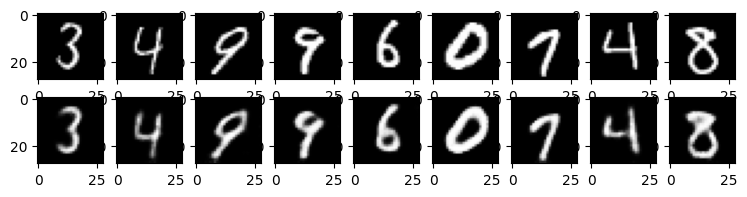

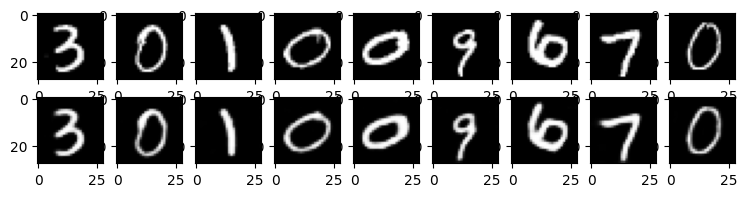

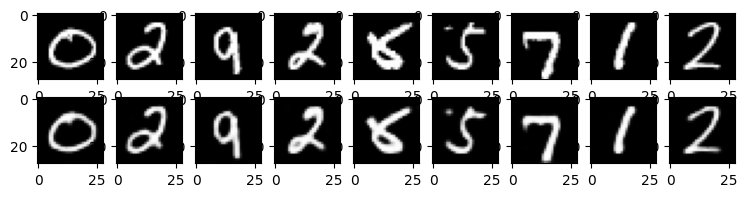

In [8]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item: 1, 28, 28
        plt.imshow(item[0])

In [9]:
def get_latent_vectors(data_loader, target_nums):
    """지정한 숫자(0~9)의 잠재 벡터를 얻는 함수"""
    latent_vectors = {}

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        for i in range(10):  # MNIST는 0~9까지 존재
            if i in target_nums and i not in latent_vectors:
                idx = (labels == i).nonzero(as_tuple=True)[0]
                if len(idx) > 0:
                    latent_vectors[i] = model.encode(images[idx[0]].unsqueeze(0))  # 1개만 저장

        if len(latent_vectors) == len(target_nums):  # 1~9까지 모두 찾으면 종료
            break

    return latent_vectors


숫자 1의 잠재 벡터 크기: torch.Size([1, 64, 1, 1])
숫자 2의 잠재 벡터 크기: torch.Size([1, 64, 1, 1])
숫자 3의 잠재 벡터 크기: torch.Size([1, 64, 1, 1])
숫자 4의 잠재 벡터 크기: torch.Size([1, 64, 1, 1])
숫자 5의 잠재 벡터 크기: torch.Size([1, 64, 1, 1])
숫자 6의 잠재 벡터 크기: torch.Size([1, 64, 1, 1])
숫자 7의 잠재 벡터 크기: torch.Size([1, 64, 1, 1])
숫자 8의 잠재 벡터 크기: torch.Size([1, 64, 1, 1])
숫자 9의 잠재 벡터 크기: torch.Size([1, 64, 1, 1])


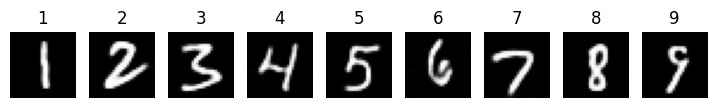

In [10]:

# 1~9 숫자의 잠재 벡터 구하기
latent_vectors = get_latent_vectors(data_loader, target_nums=list(range(1, 10)))

# 확인
for num, vec in latent_vectors.items():
    print(f"숫자 {num}의 잠재 벡터 크기:", vec.shape)

plt.figure(figsize=(9, 2))
for i, num in enumerate(range(1, 10)):
    z = latent_vectors[num]  # 저장된 잠재 벡터
    generated_img = model.decode(z).cpu().numpy()

    plt.subplot(1, 9, i+1)
    plt.imshow(generated_img[0, 0], cmap='gray')
    plt.axis('off')
    plt.title(f"{num}")

plt.show()